# MCPRO > Simulation d'un régulateur de vitesse de véhicule (débriefing)

In [27]:
%plot inline -s 640,480 -f png
%------------------------------------------------------------------------------------------
% Première cellule de code
%------------------------------------------------------------------------------------------
% Ne modifiez PAS le contenu de cette cellule, mais exécutez-là une fois (bouton run)
%------------------------------------------------------------------------------------------

% Taille des caractères pour les graphiques
set (0, "defaultaxesfontsize", 14);

% Fonction de simulation du système en boucle fermée. Reçoit les paramètres du régulateur PID testé, et affiche les résultats.
function simulateCloseLoop(k,process)

    controller.kp = k(1);
    controller.ki = k(2);
    controller.kd = k(3);

    % Définition de la consigne (vitesse cible) sous forme d'échelons
    setpoint.time = [0, 120, 240, 360]; % Temps (s)
    setpoint.value = [0, 80, 130, 80]; % Vitesse (km/h)

    % Paramètres de la simulation
    N = 361; % Nombre de points
    tend = setpoint.time(end); 
    t = linspace(0, tend, N);
    dt = t(2)-t(1); 

    % Caractéristiques du procédé (véhicule)
    process.input.min = 0;
    process.input.max = 100;

    % Calcul des coefficients du modèle (continu et discret)
    tau = -process.model.t100/log(1-100/process.model.vmax); % Constante de temps (s)
    K = process.model.vmax; % Gain statique (km/h/%)
    process.model.a = exp(-dt/tau); % Coefficient de l'équation aux différences
    process.model.b = K*(1-process.model.a)/(process.input.max-process.input.min); % Coefficient de l'équation aux différences

    % Valeurs initiales des variables
    controller.e = 0; controller.se = 0;
    u = zeros(size(t)); y = zeros(size(t));
    w = interp1(setpoint.time, setpoint.value, t, 'next', setpoint.value(end));

    % Fonction de calcul de la sortie du régulateur (entrée du procédé)
    function [value, controller] = calculateController(process, controller, w, y, step)
        e = w - y;
        controller.se = controller.se + e*step;
        de = (e-controller.e)/step;
        controller.e = e;

        value = controller.kp*controller.e + controller.ki*controller.se + controller.kd*de;
        value = max(min(value, process.input.max), process.input.min);
    end

    % Boucle principale de calcul
    for i=2:length(t)

        % Calcul de la sortie du procédé (vitesse réelle) à l'instant t
        y(i) = process.model.a*y(i-1) + process.model.b*u(i-1);

        % Calcul de la sortie du régulateur -> entrée du procédé (taux d'accélération)
        [value, controller] = calculateController(process, controller, w(i), y(i), dt);
        u(i) = value;
    end

    % Calcul du score
    score = round(10*max(0, sum(abs(w))/sum(abs(w-y)) + 1000*mean(u)/sum(abs(mean(u)-u)) - 1000*length(find(u<=process.input.min | u>=process.input.max))/length(t)));
    
    % Affichage du résultat
    disp(sprintf('kp = %.2f,  ki = %.2f,  kd  = %.2f  -->  Score = %d', controller.kp, controller.ki, controller.kd, score))

    % Tracé des courbes
    subplot(2,1,1); plot(t,u); 
    xlabel('temps (s)')
    ylabel('position accelerateur (%)')
    title(process.name)
    subplot(2,1,2); plot(t,w,t,y); 
    xlabel('temps (s)')
    ylabel('vitesse (km/h)')
    legend('consigne', 'mesure')

end

## Exemple de mauvais résultat (Porsche 911 Carrera 4 GTS)

kp = 1.00,  ki = 1.00,  kd  = 1.00  -->  Score = 0


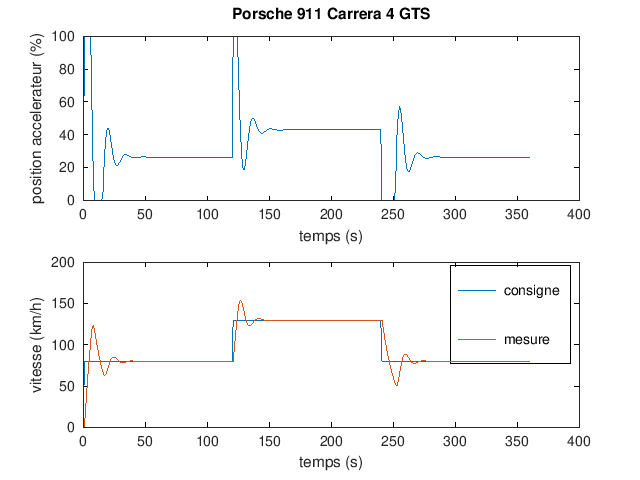

In [28]:
clear

% Caractéristiques du procédé contrôlé (véhicule)
process.name = 'Porsche 911 Carrera 4 GTS';
process.model.vmax = 302; % Vitesse maximum (km/h)
process.model.t100 = 4.8; % Temps de 0 à 100 km/h (s)

% Paramètres du régulateur PID
kp = 1.0;
ki = 1.0;
kd = 1.0;

% Lancement de la simulation
simulateCloseLoop([kp ki, kd], process);

## Exemple de bon résultat (Porsche 911 Carrera 4 GTS)

kp = 1.30,  ki = 0.11,  kd  = 0.00  -->  Score = 564


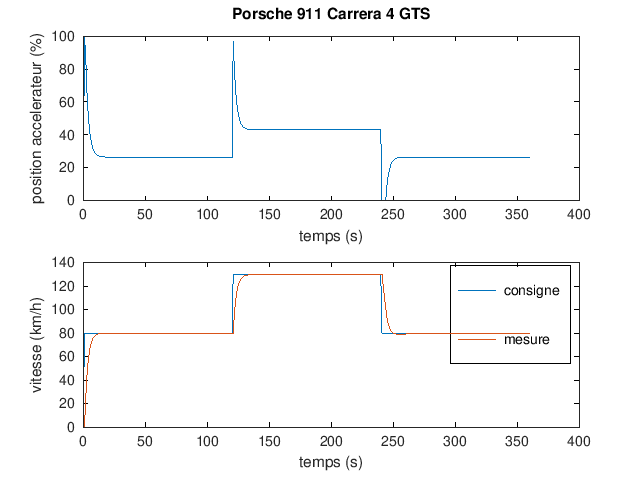

In [29]:
clear 

% Caractéristiques du procédé contrôlé (véhicule)
process.name = 'Porsche 911 Carrera 4 GTS';
process.model.vmax = 302; % Vitesse maximum (km/h)
process.model.t100 = 4.8; % Temps de 0 à 100 km/h (s)

% Paramètres du régulateur PID
kp = 1.3;
ki = 0.11;
kd = 0;

% Lancement de la simulation
simulateCloseLoop([kp, ki, kd], process);

## Exemple de bon résultat (Renault Clio 4 0.9 TCE)

kp = 1.03,  ki = 0.09,  kd  = 0.00  -->  Score = 327


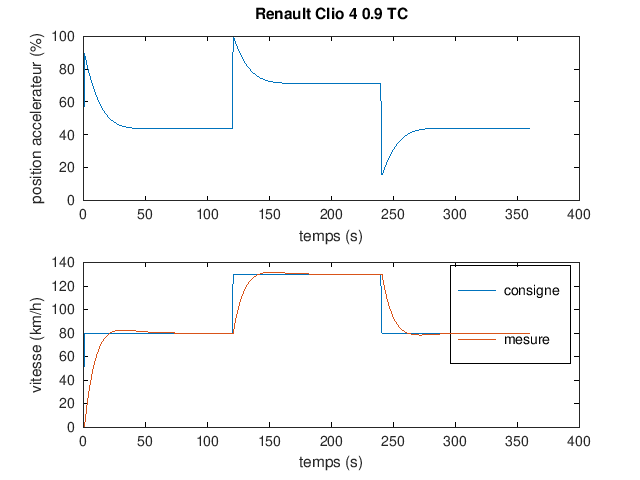

In [30]:
clear 

% Caractéristiques du procédé contrôlé (véhicule)
process.name = 'Renault Clio 4 0.9 TC';
process.model.vmax = 182; % Vitesse maximum (km/h)
process.model.t100 = 13.3; % Temps de 0 à 100 km/h (s)

% Paramètres du régulateur PID
kp = 1.03;
ki = 0.09;
kd = 0;

% Lancement de la simulation
simulateCloseLoop([kp, ki, kd], process);

## Répartition des scores obtenus

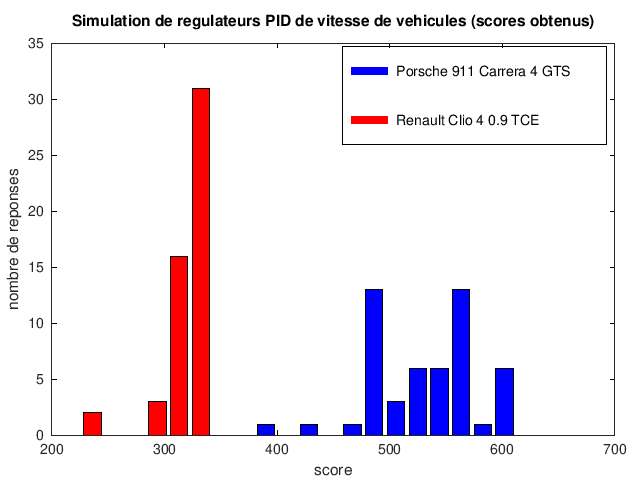

In [31]:
data = load('data/ReponsesPID2020.txt');
xbins = linspace(min([data(:,4) ; data(:,8)]), max([data(:,4) ; data(:,8)]), 20);
[p1,x1] = hist(data(:,4), xbins);
[p2,x2] = hist(data(:,8), xbins);
bar(x1,p1,'b'); hold on; bar(x2,p2,'r'); hold off
title('Simulation de regulateurs PID de vitesse de vehicules (scores obtenus)')
xlabel('score')
ylabel('nombre de reponses')
legend('Porsche 911 Carrera 4 GTS', 'Renault Clio 4 0.9 TCE')

## Explication du calcul du score

Le score prend en compte :
- L'erreur cumulée entre la consigne et la mesure sur toute la durée de la simulation : $\sum \left |w-y\right |$
- La variation cumulée de la commande par rapport à sa moyenne sur toute la durée de la simulation : $\sum \left | \bar{u}-u \right |$ 
- Le pourcentage de temps pendant lequel la commande calculée est hors des limites physiques : $\frac{duree\left \{ u>100 \% \right \} + duree \left \{ u<0 \% \right \}}{duree \: totale}$
- Quelques coefficients arbitraires pour combiner ces trois critères...

$score = \frac{\sum \left | w \right |}{\sum \left | w-y \right |} + 1000 \cdot \frac{\bar{u}}{\sum \left | \bar{u}-u \right |} + 1000\cdot \frac{duree\left \{ u>100 \% \right \} + duree \left \{ u<0 \% \right \}}{duree \: totale} $ $\rightarrow$ multiplié par 10 et arrondi à l'entier naturel le plus proche.

## Explication de la modélisation des véhicules

Hypothèses de modélisation :
- Lors d'un départ arrêté, avec une accélération qui passe brusquement du minimum (0%) au maximum (100%), la vitesse des véhicules atteint 100km/h au bout du temps $t_{100}$ et se stabilise à la vitesse $v_{max}$ (données fournies par les constructeurs). 
- Les véhicules sont considérés comme des systèmes dynamiques du premier ordre.

In [32]:
% Extraits de code

process1.name = 'Porsche 911 Carrera 4 GTS';
process1.model.vmax = 302; % Vitesse maximum (km/h)
process1.model.t100 = 4.8; % Temps de 0 à 100 km/h (s)

process2.name = 'Renault Clio 4 0.9 TCE';
process2.model.vmax = 182; % Vitesse maximum (km/h)
process2.model.t100 = 13.3; % Temps de 0 à 100 km/h (s)

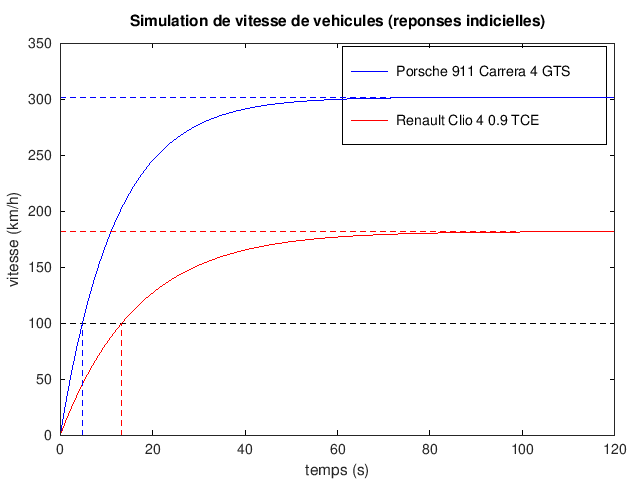

In [34]:
% Calcul des paramètres du modèle 1
tau1 = -process1.model.t100/log(1-100/process1.model.vmax); % Constante de temps (s)
K1 = process1.model.vmax; % Gain statique (km/h/%)

% Calcul des paramètres du modèle 2
tau2 = -process2.model.t100/log(1-100/process2.model.vmax); % Constante de temps (s)
K2 = process2.model.vmax; % Gain statique (km/h/%)

% Calcul des réponses indicielles
t = linspace(0,120);
y1 = K1*(1-exp(-t/tau1));
y2 = K2*(1-exp(-t/tau2));

% Tracé des courbes
u = 100*ones(size(t)); u(1) = 0;

plot(t,y1,'b',t,y2,'r')
title('Simulation de vitesse de vehicules (reponses indicielles)')
hold on
plot(t,100*ones(size(t)),'k--')
plot(t,process1.model.vmax*ones(size(t)), 'b--')
plot(process1.model.t100*ones(2),[0 100], 'b--')
plot(t,process2.model.vmax*ones(size(t)), 'r--')
plot(process2.model.t100*ones(2),[0 100], 'r--')
hold off
xlabel('temps (s)')
ylabel('vitesse (km/h)')
legend('Porsche 911 Carrera 4 GTS', 'Renault Clio 4 0.9 TCE')